In [ ]:
# Step 1: Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.filterwarnings('ignore')



In [ ]:
# Upload the file from your system
import kagglehub

# Download latest version
path = kagglehub.dataset_download("casimian2000/aws-honeypot-attack-data")

print("Path to dataset files:", path)

100%|██████████| 6.17M/6.17M [00:00<00:00, 137MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/casimian2000/aws-honeypot-attack-data/versions/1


In [ ]:
import os

# List all files in the downloaded dataset directory
for root, dirs, files in os.walk(path):
    for file in files:
        print(os.path.join(root, file))


/root/.cache/kagglehub/datasets/casimian2000/aws-honeypot-attack-data/versions/1/AWS_Honeypot_marx-geo.csv


In [ ]:
# Step 2: Load the dataset
file_path = '/root/.cache/kagglehub/datasets/casimian2000/aws-honeypot-attack-data/versions/1/AWS_Honeypot_marx-geo.csv'
df = pd.read_csv(file_path, on_bad_lines='warn')

In [ ]:
# Print all column names and their types
print("\n🔍 Column Names and Data Types:\n")
print(df.dtypes)

# Show first few rows to understand what's inside
print("\n📊 Sample Data:\n")
print(df.head())




🔍 Column Names and Data Types:

datetime        object
host            object
src              int64
proto           object
type           float64
spt            float64
dpt            float64
srcstr          object
cc              object
country         object
locale          object
localeabbr      object
postalcode      object
latitude       float64
longitude      float64
Unnamed: 15    float64
dtype: object

📊 Sample Data:

       datetime               host         src proto  type      spt     dpt  \
0  3/3/13 21:53     groucho-oregon  1032051418   TCP   NaN   6000.0  1433.0   
1  3/3/13 21:57     groucho-oregon  1347834426   UDP   NaN   5270.0  5060.0   
2  3/3/13 21:58     groucho-oregon  2947856490   TCP   NaN   2489.0  1080.0   
3  3/3/13 21:58    groucho-us-east   841842716   UDP   NaN  43235.0  1900.0   
4  3/3/13 21:58  groucho-singapore  3587648279   TCP   NaN  56577.0    80.0   

            srcstr  cc        country         locale localeabbr postalcode  \
0   61.131.218.

In [ ]:
# Step 3: Clean column names
df.columns = df.columns.str.strip()

# Step 4: Basic data info
print("First few rows:\n", df.head())
print("\nMissing values:\n", df.isnull().sum())
print("\nData summary:\n", df.describe())

# Step 5: Drop columns with too many missing values
threshold = 0.5
df = df[df.columns[df.isnull().mean() < threshold]]

# Step 6: Drop any remaining missing values
df = df.dropna()

# Improved attack labeling using statistical approach
ip_counts = df['src'].value_counts()
attack_threshold = ip_counts.mean() + 2 * ip_counts.std()  # Statistical threshold
malicious_ips = ip_counts[ip_counts > attack_threshold].index
df['attack'] = df['src'].apply(lambda x: 1 if x in malicious_ips else 0)

# Drop unnecessary columns
drop_cols = ['srcip', 'locale', 'localeabbr', 'datetime', 'srcstr', 'Unnamed: 15', 'postalcode']
df = df.drop(columns=[col for col in drop_cols if col in df.columns])



First few rows:
        datetime               host         src proto  type      spt     dpt  \
0  3/3/13 21:53     groucho-oregon  1032051418   TCP   NaN   6000.0  1433.0   
1  3/3/13 21:57     groucho-oregon  1347834426   UDP   NaN   5270.0  5060.0   
2  3/3/13 21:58     groucho-oregon  2947856490   TCP   NaN   2489.0  1080.0   
3  3/3/13 21:58    groucho-us-east   841842716   UDP   NaN  43235.0  1900.0   
4  3/3/13 21:58  groucho-singapore  3587648279   TCP   NaN  56577.0    80.0   

            srcstr  cc        country         locale localeabbr postalcode  \
0   61.131.218.218  CN          China  Jiangxi Sheng         36        NaN   
1      80.86.82.58  DE        Germany            NaN        NaN        NaN   
2  175.180.184.106  TW         Taiwan         Taipei        NaN        NaN   
3     50.45.128.28  US  United States         Oregon         OR      97124   
4    213.215.43.23  FR         France            NaN        NaN        NaN   

   latitude  longitude  Unnamed: 15  
0

In [ ]:
# Verify no missing values remain
print("\nMissing values after cleaning:\n", df.isnull().sum())




Missing values after cleaning:
 host         0
src          0
proto        0
spt          0
dpt          0
cc           0
country      0
latitude     0
longitude    0
attack       0
dtype: int64


In [ ]:
# Enhanced categorical encoding
le = LabelEncoder()
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col] = le.fit_transform(df[col].astype(str))



In [ ]:
# Prepare features and target
X = df.drop('attack', axis=1)
y = df['attack']



In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



In [ ]:
# Handle class imbalance
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)



In [ ]:
# Robust scaling for outlier handling
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)



In [ ]:
# Feature selection
selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))
selector.fit(X_train_scaled, y_train_balanced)
X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)



In [ ]:
# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_selected, y_train_balanced)



GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, None],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='f1')

In [ ]:
# Best model
best_model = grid_search.best_estimator_
print("\nBest parameters:", grid_search.best_params_)




Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
# Cross-validation
cv_scores = cross_val_score(best_model, X_train_selected, y_train_balanced, cv=5)
print("\nCross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())




Cross-validation scores: [0.98906883 0.98830995 0.98931086 0.98881031 0.98845508]
Mean CV score: 0.9887910050417222


In [ ]:
# Final predictions
y_pred = best_model.predict(X_test_selected)
print("\nClassification Report:\n", classification_report(y_test, y_pred))




Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     66384
           1       0.95      1.00      0.97     24380

    accuracy                           0.98     90764
   macro avg       0.97      0.99      0.98     90764
weighted avg       0.99      0.98      0.98     90764



In [ ]:
# Calculate and print accuracy
accuracy = (y_pred == y_test).mean()
print(f"\nModel Accuracy: {accuracy:.4f}")




Model Accuracy: 0.9845


In [ ]:
# Print confusion matrix with percentages
cm = confusion_matrix(y_test, y_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
print("\nConfusion Matrix (Percentages):")
print(cm_percentage)




Confusion Matrix (Percentages):
[[98.0175946  1.9824054]
 [ 0.3609516 99.6390484]]


In [ ]:
# ROC curve
y_probs = best_model.predict_proba(X_test_selected)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
print(f"\nROC AUC Score: {roc_auc:.4f}")




ROC AUC Score: 0.9993


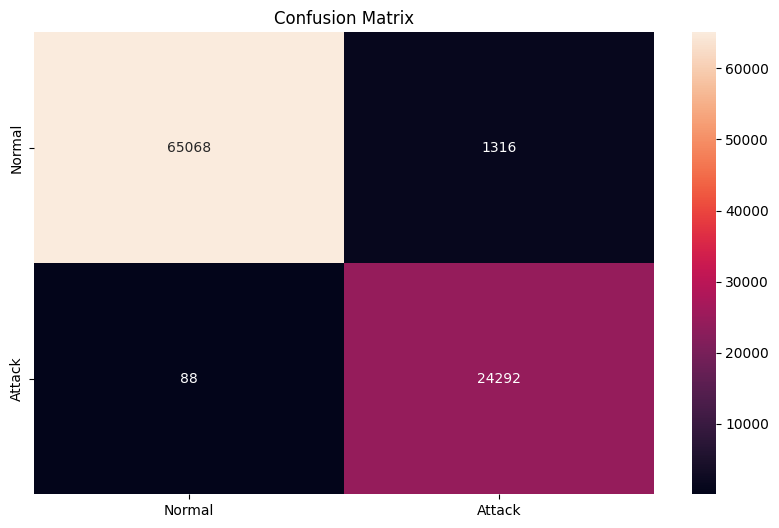

In [ ]:
# Visualizations
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.title('Confusion Matrix')
plt.show()



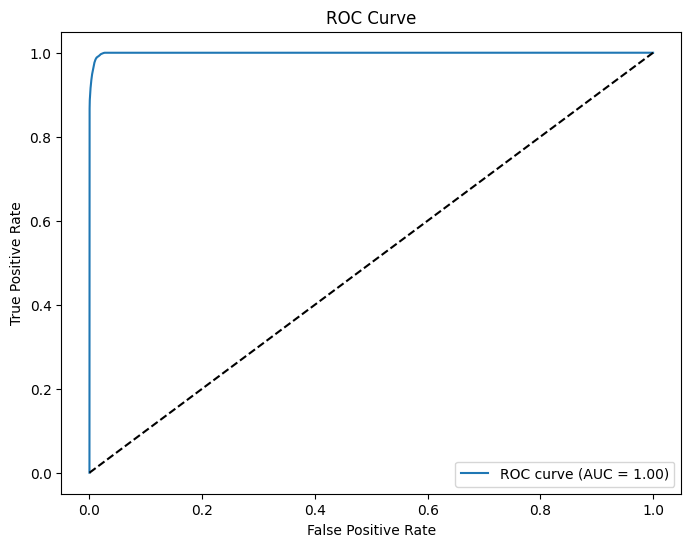

In [ ]:
# ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()



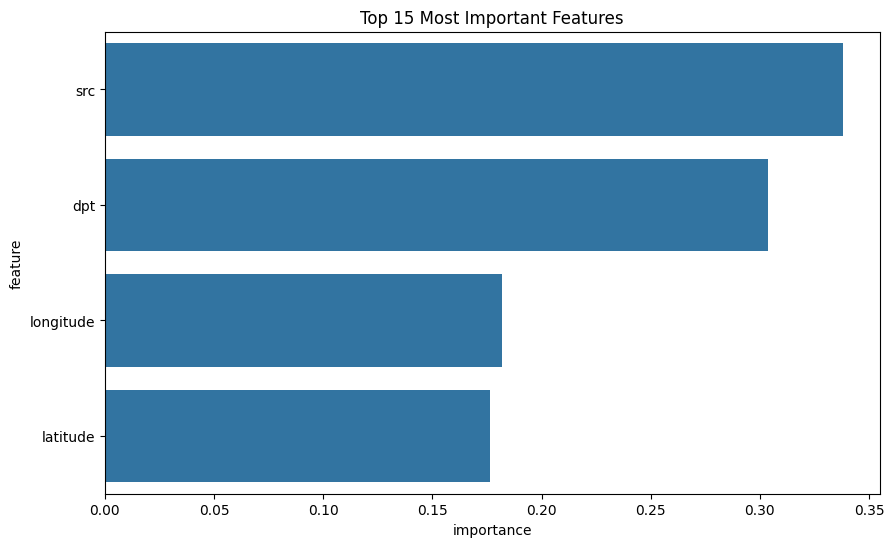

In [ ]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns[selector.get_support()],
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
plt.title('Top 15 Most Important Features')
plt.show()